# Codewars Solutions Analysis

## Imports

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import requests
import bs4 as BeautifulSoup
from time import sleep
%matplotlib inline

In [183]:
# Set style to Solarize_Light2, the best style
plt.style.use('Solarize_Light2')

In [111]:
# Load the dataframe from .csv so we can ensure we don't create duplicate entries
# Also so we don't have to scrape the site fully every time we run the notebook
if os.path.isfile('codewars.csv'):
    codewars_df = pd.read_csv('codewars.csv')

## Looping through data files

In [112]:
# This will loop through every file in the data folder and extract the link
path = "data/"

for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            link = f.readline().strip()
            print(link)

# https://www.codewars.com/kata/58ce8725c835848ad6000007
# https://www.codewars.com/kata/56bc28ad5bdaeb48760009b0
# https://www.codewars.com/kata/59bfe5f15227ddf81900007b
# https://www.codewars.com/kata/582cb0224e56e068d800003c
# https://www.codewars.com/kata/563a631f7cbbc236cf0000c2
# https://www.codewars.com/kata/582cd9033c1acf1d45000052
# https://www.codewars.com/kata/582cb0224e56e068d800003c
# https://www.codewars.com/kata/57a0e5c372292dd76d000d7e
# https://www.codewars.com/kata/51f2b4448cadf20ed0000386
# https://www.codewars.com/kata/58261acb22be6e2ed800003a
# https://www.codewars.com/kata/55cb632c1a5d7b3ad0000145
# https://www.codewars.com/kata/554e4a2f232cdd87d9000038
# https://www.codewars.com/kata/56541980fa08ab47a0000040
# https://www.codewars.com/kata/5a03b3f6a1c9040084001765
# https://www.codewars.com/kata/55a70521798b14d4750000a4
# https://www.codewars.com/kata/55fd2d567d94ac3bc9000064
# https://www.codewars.com/kata/58261acb22be6e2ed800003a
# https://www.codewars.com/kata

## Generating dictionary for dataframe

In [113]:
# regex to extract the kata ID
pattern = re.compile(r'^.*kata/(.*)$')
# regex to extract version number
revision_pattern = re.compile(r'.*-v(\d+)-.*')

In [114]:
# Loop through all files to collect kata ID, language and revision numbers
data_list = []

base_url = "https://www.codewars.com/kata/"

# Check if dataframe exists
dataframe_exists = False
if os.path.isfile('codewars.csv'):
    dataframe_exists = True

# loop through files
for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            lines = f.readlines()

            # extract problem id from first line of file
            first_line = lines[0].strip()
            problem_id = re.search(pattern, first_line).group(1)
            
            # extract date from second line of file
            date = lines[1].strip()
            # remove comment if it exists
            date = re.search(r"^.*?(\d{4}.*)$", date).group(1)
            date = re.sub(r'T', ' ', date)
            date = re.sub(r'\+\d{4}', '', date)
            
            # Before we continue, check if we already have an entry for this kata
            # The date will be unique, since it's down to the nearest millisecond
            # so we can use that to check
            if dataframe_exists and codewars_df[codewars_df['date_time'] == date].shape[0] > 0:
                continue
            
            # construct link
            link = base_url + problem_id

            # extract language from folder name
            language = os.path.basename(root)

            # extract revision from file name
            match = re.search(revision_pattern, name)
            if match:
                revision = match.group(1)
            else:
                revision = 1

            # extract solution from file contents
            solution = '\n'.join(lines[2:])

            # create dictionary and add to list
            data_dict = {
                'problem_id': problem_id,
                'language': language,
                'revision': int(revision),
                'solution': solution,
                'link': link,
                'date_time': date
            }
            data_list.append(data_dict)

data_list

[]

### Test Webscrape

In [115]:
# Now we can begin scraping
# This is just a sample scraping function so we can verify it works
# We're limited in what we can scrape without being logged in
# So we can't get the description satisfaction information and number of completions per language
# If we so desired we could use Selenium to log in and scrape that information

# Scrape max 5 problems as a test
counter = 5
for problem in data_list:
    link = problem['link']
    response = requests.get(link)
    soup = BeautifulSoup.BeautifulSoup(response.text, 'html.parser')
    # Difficulty is in a span in a div with class inner-small-hex
    difficulty = soup.find('div', {'class': 'inner-small-hex'}).find('span').text
    # Get title from the meta tag og:title
    title = soup.find('meta', {'property': 'og:title'})['content']
    # Find a div with data-id equivalent to the problem_id
    extra_info = soup.find('div', {'data-id': problem['problem_id']})
    # Extract the number of completions - this is a tuple
    completion_count = re.search(r'([\d+,]+)\s*(?:of)?\s*([\d,]+)?', extra_info.text).groups()
    completion_count= int(completion_count[1].replace(',', '')) if completion_count[1] else int(completion_count[0].replace(',', ''))
    # Author
    author = extra_info.find('a').text
    # Tags
    # Search the soup for all divs with class keyword-tag
    tags = soup.find_all('div', {'class': 'keyword-tag'})
    tag_texts = []
    for tag in tags:
        tag_texts.append(tag.text)
        
    # Add to problem dictionary
    problem['difficulty'] = difficulty
    problem['title'] = title
    problem['completion_count'] = completion_count
    problem['author'] = author
    problem['tags'] = tag_texts
    
    print(problem)
    
    counter -= 1
    if counter == 0:
        break

### Full Web Scrape

In [116]:
# This is a full web scrape of all problems
# We limit it to 10s between requests to avoid overloading the server

problem_num = 0
for problem in data_list:
    problem_num += 1
    # We should first check if the problem has already been scraped e.g. by the test scraper
    # There won't be a difficulty attribute if it hasn't been scraped
    if 'difficulty' in problem:
        continue
    
    link = problem['link']
    print("Scraping problem {} of {}".format(problem_num, len(data_list)))
    print("Link: " + link)
    response = requests.get(link)
    soup = BeautifulSoup.BeautifulSoup(response.text, 'html.parser')
    # Difficulty is in a span in a div with class inner-small-hex
    difficulty = soup.find('div', {'class': 'inner-small-hex'}).find('span').text
    # Get title from the meta tag og:title
    title = soup.find('meta', {'property': 'og:title'})['content']
    # Find a div with data-id equivalent to the problem_id
    extra_info = soup.find('div', {'data-id': problem['problem_id']})
    # Extract the number of completions - this is a tuple
    completion_count = re.search(r'([\d+,]+)\s*(?:of)?\s*([\d,]+)?', extra_info.text).groups()
    completion_count= int(completion_count[1].replace(',', '')) if completion_count[1] else int(completion_count[0].replace(',', ''))
    # Author
    author = extra_info.find('a')
    if author:
        author = author.text
    else:
        author = ""
    # Tags
    # Search the soup for all divs with class keyword-tag
    tags = soup.find_all('div', {'class': 'keyword-tag'})
    tag_texts = []
    for tag in tags:
        tag_texts.append(tag.text)
        
    # Add to problem dictionary
    problem['difficulty'] = difficulty
    problem['title'] = title
    problem['completion_count'] = completion_count
    problem['author'] = author
    problem['tags'] = tag_texts
    
    
    # Add a sleep time to avoid being blocked
    sleep(10)

### Store Data in Dataframe
Note the dataframe name. This is because codewars_df may already exist
We with to only append new data

In [117]:
# Now we have some new data, let's make a dataframe
new_codewars_df = pd.DataFrame(data_list)
new_codewars_df.head()

""


In [118]:
new_codewars_df.shape

(0, 0)

In [119]:
new_codewars_df.tail()

""


In [120]:
# Completion count should be an integer
if new_codewars_df.shape[0] > 0:
    new_codewars_df['completion_count'] = new_codewars_df['completion_count'].astype(int)

### Append New Data to Stored Dataframe
If the dataframe existed before we started, we may have scraped new data to append

In [121]:
# Append new data to the end of the old dataframe
# We need to check the df exists first incase this is the first scrape
if 'codewars_df' in locals():
    codewars_df = codewars_df.append(new_codewars_df, ignore_index=True)
else:
    codewars_df = new_codewars_df

# Free up some memory since it's now stored twice
del new_codewars_df

/tmp/ipykernel_10694/1390956106.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  codewars_df = codewars_df.append(new_codewars_df, ignore_index=True)


In [122]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,difficulty,title,completion_count,author,tags
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,7 kyu,Drying Potatoes,9448,g964,"['Fundamentals', 'Puzzles']"
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,8 kyu,Remove First and Last Character,215262,Steadyx,"['Strings', 'Fundamentals']"
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,7 kyu,Return the latest modified file,327,ddellaquila,['Fundamentals']
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,8 kyu,Keep Hydrated!,154528,paulrichard,"['Algorithms', 'Mathematics', 'Fundamentals']"
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,8 kyu,Grasshopper - Terminal game move function,44795,danleavitt0,['Fundamentals']


In [123]:
codewars_df.shape

(285, 11)

### Save Dataframe as CSV

In [124]:
# Save dataframe to csv
codewars_df.to_csv('codewars.csv', index=False)

### Inspect Dataframe

In [125]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,difficulty,title,completion_count,author,tags
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,7 kyu,Drying Potatoes,9448,g964,"['Fundamentals', 'Puzzles']"
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,8 kyu,Remove First and Last Character,215262,Steadyx,"['Strings', 'Fundamentals']"
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,7 kyu,Return the latest modified file,327,ddellaquila,['Fundamentals']
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,8 kyu,Keep Hydrated!,154528,paulrichard,"['Algorithms', 'Mathematics', 'Fundamentals']"
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,8 kyu,Grasshopper - Terminal game move function,44795,danleavitt0,['Fundamentals']


In [126]:
codewars_df.tail()

,problem_id,language,revision,solution,link,date_time,difficulty,title,completion_count,author,tags
280,55a2d7ebe362935a210000b2,C,1,#include <stddef.h>\n\n\n\nint find_smallest_i...,https://www.codewars.com/kata/55a2d7ebe362935a...,2023-03-11 15:50:33.460,8 kyu,Find the smallest integer in the array,192977,dukeofgarda,['Fundamentals']
281,57a0885cbb9944e24c00008e,C,1,#include <string.h>\n\n\n\n// Write resulting ...,https://www.codewars.com/kata/57a0885cbb9944e2...,2023-03-11 15:56:53.707,8 kyu,Remove exclamation marks,72652,wichu,"['Fundamentals', 'Strings']"
282,5715eaedb436cf5606000381,C#,1,using System;\n\nusing System.Linq;\n\n\n\npub...,https://www.codewars.com/kata/5715eaedb436cf56...,2023-05-03 14:16:10.209,8 kyu,Sum of positive,226853,JbPasquier,"['Arrays', 'Fundamentals']"
283,55cbc3586671f6aa070000fb,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/55cbc3586671f6aa...,2023-05-03 14:11:40.738,8 kyu,Grasshopper - Check for factor,52540,danleavitt0,"['Mathematics', 'Fundamentals']"
284,557cd6882bfa3c8a9f0000c1,C#,1,using System;\n\n\n\npublic class Kata\n\n{\n\...,https://www.codewars.com/kata/557cd6882bfa3c8a...,2023-05-03 12:55:15.402,8 kyu,Parse nice int from char problem,57474,Joz,['Fundamentals']


In [127]:
codewars_df.shape

(285, 11)

In [128]:
codewars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   problem_id        285 non-null    object
 1   language          285 non-null    object
 2   revision          285 non-null    int64 
 3   solution          285 non-null    object
 4   link              285 non-null    object
 5   date_time         285 non-null    object
 6   difficulty        285 non-null    object
 7   title             285 non-null    object
 8   completion_count  285 non-null    int64 
 9   author            284 non-null    object
 10  tags              285 non-null    object
dtypes: int64(2), object(9)
memory usage: 24.6+ KB


In [129]:
codewars_df.dtypes

problem_id          object
language            object
revision             int64
solution            object
link                object
date_time           object
difficulty          object
title               object
completion_count     int64
author              object
tags                object
dtype: object

In [130]:
# Set the date_time column to datetime
codewars_df['date_time'] = pd.to_datetime(codewars_df['date_time'])

In [131]:
codewars_df.dtypes

problem_id                  object
language                    object
revision                     int64
solution                    object
link                        object
date_time           datetime64[ns]
difficulty                  object
title                       object
completion_count             int64
author                      object
tags                        object
dtype: object

In [139]:
# Check how many invalid authors there are
codewars_df[(codewars_df['author'] == '') | (codewars_df['author'].isnull())]

,problem_id,language,revision,solution,link,date_time,difficulty,title,completion_count,author,tags
93,50654ddff44f800200000004,Python,1,"def multiply(a, b):\n\n return a * b",https://www.codewars.com/kata/50654ddff44f8002...,2023-03-07 19:01:20.838,8 kyu,Multiply,5475116,NaN,"['Debugging', 'Fundamentals']"


In [133]:
codewars_df.describe()

,revision,completion_count
count,285.000000,2.850000e+02
mean,1.108772,1.034035e+05
std,0.333716,3.303257e+05
min,1.000000,2.900000e+01
25%,1.000000,1.914700e+04
50%,1.000000,6.492700e+04
75%,1.000000,1.292950e+05
max,3.000000,5.475116e+06


## Analysis

### Analysis of Tags

In [134]:
import ast
# Create a series by extracting the tags column as a list
tags_series = pd.Series(codewars_df['tags'].apply(ast.literal_eval))

In [140]:
# Let's get a list of tags
tag_counts = {}
for tag_list in tags_series:
    for tag in tag_list:
        if tag not in tag_counts:
            tag_counts[tag] = 1
        else:
            tag_counts[tag] += 1
            
# Get tag_counts sorted by value
sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

[('Fundamentals', 248),
 ('Strings', 82),
 ('Arrays', 59),
 ('Algorithms', 52),
 ('Mathematics', 31),
 ('Regular Expressions', 31),
 ('SQL', 23),
 ('Lists', 12),
 ('Databases', 10),
 ('Geometry', 5),
 ('Data Science', 5),
 ('Puzzles', 4),
 ('Data Structures', 4),
 ('Games', 3),
 ('Date Time', 3),
 ('NumPy', 3),
 ('Filtering', 2),
 ('Parsing', 2),
 ('Sorting', 2),
 ('Object-oriented Programming', 2),
 ('ASCII Art', 2),
 ('Number Theory', 2),
 ('Logic', 2),
 ('Algebra', 2),
 ('Linear Algebra', 1),
 ('Combinatorics', 1),
 ('Graph Theory', 1),
 ('Cryptography', 1),
 ('Debugging', 1),
 ('Dynamic Programming', 1),
 ('Performance', 1),
 ('Design Patterns', 1),
 ('Permutations', 1),
 ('Refactoring', 1),
 ('Binary', 1),
 ('Ciphers', 1),
 ('Restricted', 1),
 ('Recursion', 1)]

#### Heatmap
Excluding tags with 2 or less appearances

<AxesSubplot:>

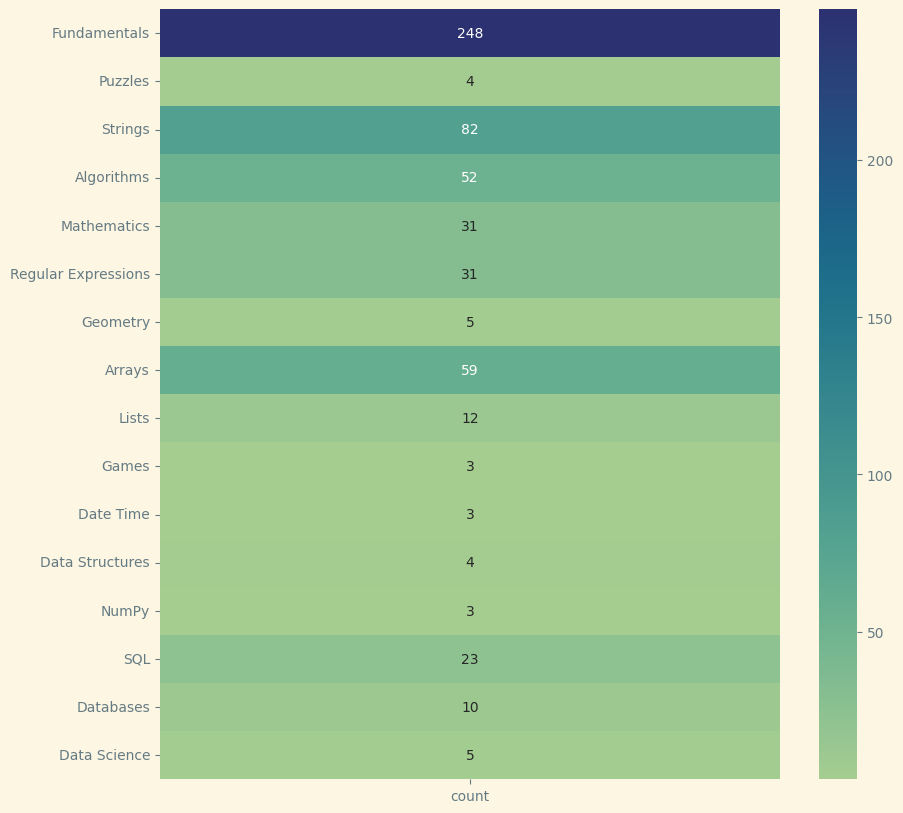

In [185]:
# Create heatmap from the dictionary
tags_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count'])

plt.figure(figsize=(10, 10))
sns.heatmap(tags_df[tags_df["count"] > 2], annot=True, fmt='g', cmap='crest')

#### Top Tag Representation Over Time

In [172]:
# Top 4 tags
top_tags = [tag for tag in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:4]]
# Get the tag names
top_tags = [tag[0] for tag in top_tags]

# Now we can analysis the tag representation over time in a new dataframe
tag_representation_df = codewars_df[['date_time', 'tags']].copy()

# Convert date time to just date
tag_representation_df['date_time'] = tag_representation_df['date_time'].dt.date
tag_representation_df['date_time'] = pd.to_datetime(tag_representation_df['date_time'])
tag_representation_df.rename(columns={'date_time': 'date'}, inplace=True)

# Convert tags to a list then create columns for each tag
tag_representation_df['tags'] = tag_representation_df['tags'].apply(ast.literal_eval)
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df['tags'].apply(lambda x: int(tag in x))

# Drop the original tags column
tag_representation_df.drop('tags', axis=1, inplace=True)

tag_representation_df.shape

(285, 5)

In [173]:
tag_representation_df.head()

,date,Fundamentals,Strings,Arrays,Algorithms
0,2023-04-08,1,0,0,0
1,2023-03-27,1,1,0,0
2,2023-04-08,1,0,0,0
3,2023-04-17,1,0,0,1
4,2023-03-31,1,0,0,0


In [175]:
# Group by date
tag_representation_df = tag_representation_df.groupby('date').sum()

In [176]:
tag_representation_df.shape

(36, 4)

In [177]:
tag_representation_df.head()

,Fundamentals,Strings,Arrays,Algorithms
date,,,,
2023-03-07,8,3,2,2
2023-03-08,5,2,2,7
2023-03-09,19,4,10,3
2023-03-10,10,4,2,0
2023-03-11,7,3,0,2


In [178]:
# Final step is to change the tag columns to sums
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df[tag].cumsum()
    
tag_representation_df.head()

,Fundamentals,Strings,Arrays,Algorithms
date,,,,
2023-03-07,8,3,2,2
2023-03-08,13,5,4,9
2023-03-09,32,9,14,12
2023-03-10,42,13,16,12
2023-03-11,49,16,16,14


Text(0.5, 1.0, 'Cumulative Count of Top 4 Tags Over Time')

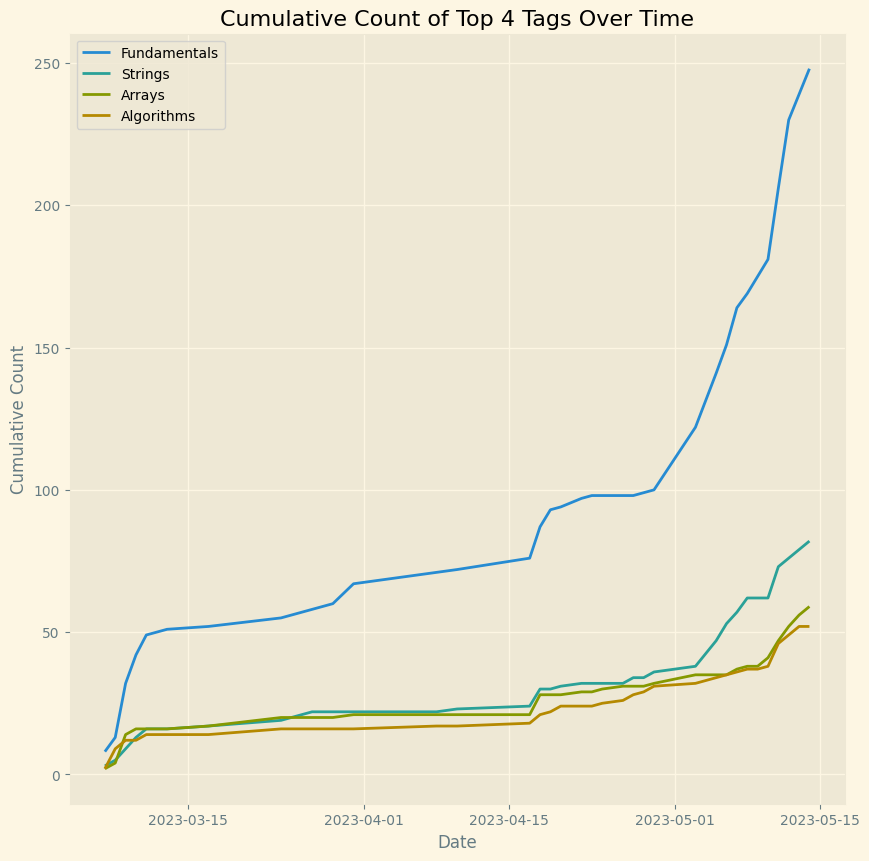

In [184]:
# Side note: I can't believe I actually got that to work
# Now we can plot the data
plt.figure(figsize=(10, 10))
sns.lineplot(data=tag_representation_df, dashes=False)
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Count of Top 4 Tags Over Time')

# TODO!

Next thing to do is write a function to scrape instead of hard-coding
The test scraper and full scraper run on different code

Initialise git submodule in folder if relevant
Fetch changes
Run scraper
Run a mv command to move any new problems to the data/ folder
We will need to import the language dict so we know the folder names